This notebook will use matplotlib (https://matplotlib.org/) for plotting 

If you would like your figures to appear inline, include the following line at the top of your cell \
%matplotlib inline \
If you would like your figures to appear in a window \
%matplotlib qt

In this lab, we will perform coil optimization for the HSX configuration using the REGCOIL and FOCUS codes. We can compare the results and assess the performance of each coil set by computing a free-boundary VMEC equilibria. 

We will begin by running the FOCUS code using the sample provided in the focus_hsx directory. This directory contains
- A sample input file (hsx.input)
- The input plasma boundary (plasma.boundary)
- A sample script for executing the job (script)
- The input coil set (hsx.focus)

This calculations initializes the optimization of a coil set using the actual HSX coil shapes in order to minimize the normal field error on the target plasma boundary. If desired, the input parameters can be adjusted (details provided in https://princetonuniversity.github.io/FOCUS/initial.pdf). Detailed documentation of the FOCUS code is provided at (https://princetonuniversity.github.io/FOCUS/). 

The objective function minimized by this example is given by

$f = w_B f_B + w_{\Psi}f_{\Psi} + w_L f_L + w_{\kappa} f_{\kappa}$

where 
- $f_B$ is an objective which targets the normal field error on the target plasma boundary
- $f_{\Psi}$ is an objective which targets a prescribed toroidal flux 
- $f_L$ is an objective which targets the coil length
- $f_{\kappa}$ is an objective which targets the coil curvature

and $w_i$ are user-specified weights. The weights are controlled by the input parameters 
- weight_bnorm
- weight_tflux
- weight_ttlen
- weight_curv

To execute the FOCUS code, perform the following steps.
- Make a directory from which you would like to run the code.
- Copy the files contained in the focus_hsx directory into your new directory.
- Edit the input file as desired.
- Execute the code using the script.

We will use the Coilpy tools from https://zhucaoxiang.github.io/CoilPy/ to perform some analysis. We will begin by importing various things.

In [4]:
import sys
import numpy as np
from cutCoilsFromRegcoil import *
from simsopt.modules.vmec.output import VmecOutput

We now plot the plasma boundary we are optimizing for

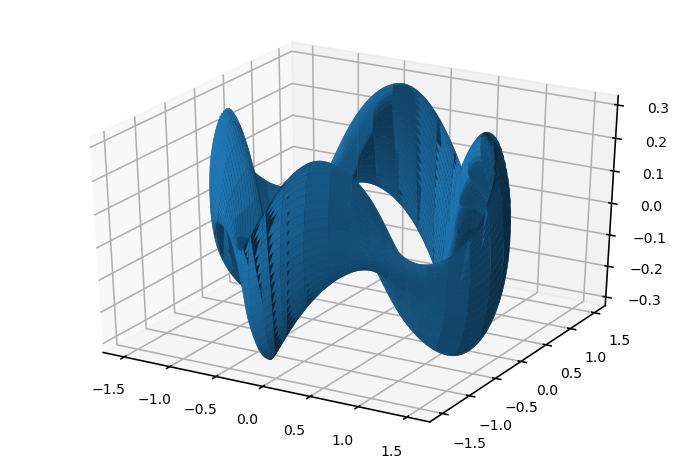

In [33]:
from coilpy.surface import FourSurf
# %matplotlib qt
plasma = FourSurf.read_focus_input('focus_hsx/plasma.boundary');
plt.figure()
[xx, yy, zz, nn] = plasma.plot3d(engine='pyplot')

We now will now plot the convergence of each of the terms in the objective function.

FOCUS version: v0.13.01


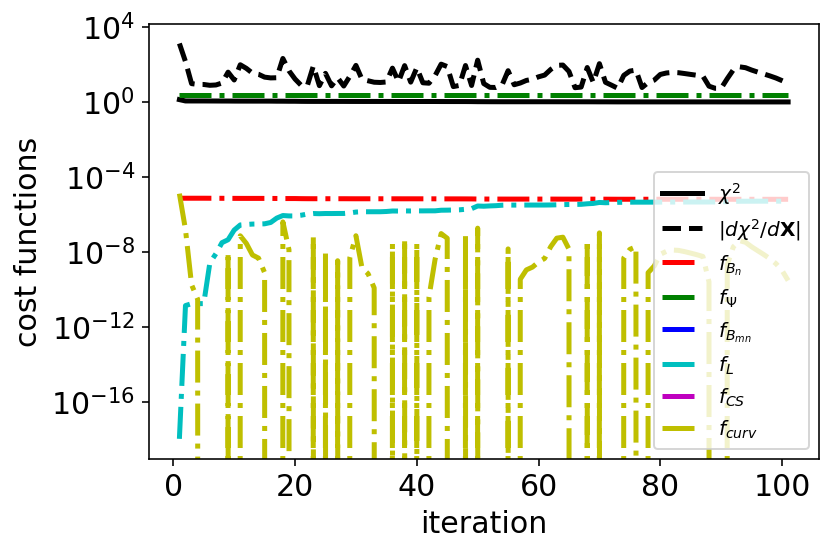

In [35]:
from coilpy.focushdf5 import FOCUSHDF5
output = FOCUSHDF5('focus_hsx/focus_hsx.h5')
output.convergence(term='all')
plt.legend(loc=4)
plt.show()

We can also plot the residual normal field on the target plasma boundary. 

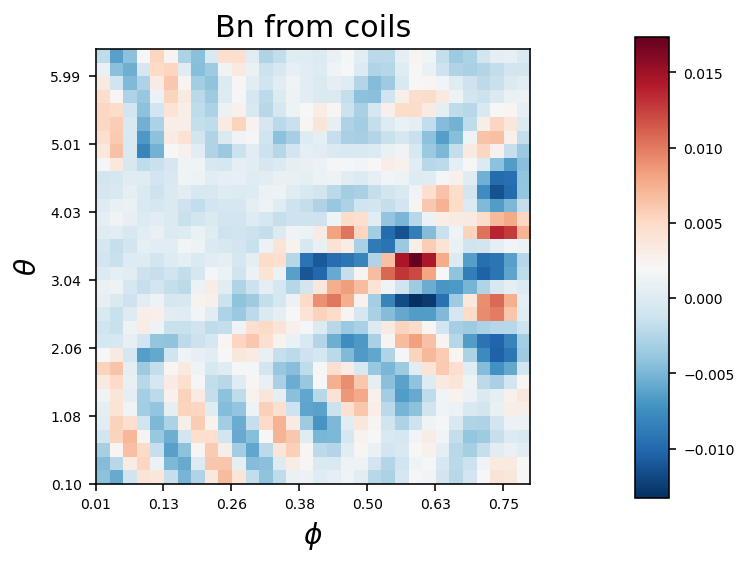

In [36]:
output.Bnorm(source='coil')

We can now compute the REGCOIL solution using the sample provided in the regcoil_hsx directory. To run this FORTRAN code, we will use the sample files provided in the regcoil_hsx directory. This directory contains:
- The winding surface on which the current potential solution will lie (nescin.hsx). This is the actual winding surface of the HSX experiment.
- The equilibrium file containing the target plasma boundary (wout_hsx.nc).
- The REGCOIL input file (regcoil_in.hsx). If desired by the user, the input parameters can be modified using the documentation (regcoilManual.pdf) contained in this directory.
- A sample script for executing the code (script) 

The REGCOIL calculation is performed assuming that all of the currents in the vacuum region lie on a winding surface, which is taken to be a surface on which the actual HSX coils lie. A continuous current density is contained supported on the winding surface ($S_C$),

$\textbf{K} = \hat{\textbf{n}} \times \nabla \Phi$,

where $\Phi$ is the current potential. The current potential is chosen to minimize an objective function,

$\chi^2 = \chi^2_B + \lambda \chi^2_K$,

where 

- $\chi^2_B = \int_{S_P} d^2 x \, \textbf{B} \cdot \hat{\textbf{n}}$ is an objective which targets the normal magnetic field on the target plasma boundary ($S_P$)
- $\chi^2_K = \int_{S_C} d^2 x \, |\textbf{K}|^2$ is an objective which targets the coil complexity
- $\lambda$ is a regularization parameter. 

In the sample input file, the regularization parameter is set such that the the following equality is satisfied

$ \sqrt{\chi^2_K/\int_{S_C} d^2 x} = \text{target_value}$.

The user can adjust the tradeoff between coil complexity and normal field error using this parameter.

Once the current potential is optimized, the coils shapes are chosen to be a set of contours of $\Phi$. 

The REGCOIL code can be called with the following steps.

1. Make a directory from which you would like to execute the code.
2. Copy the contents of regcoil_hsx into your new directory.
3. Edit the input file as desired.
4. Execute using the script.

We can now plot features of the REGCOIL solution using the regcoilPlot script contained in this directory.

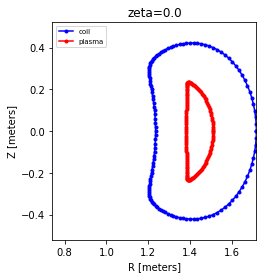

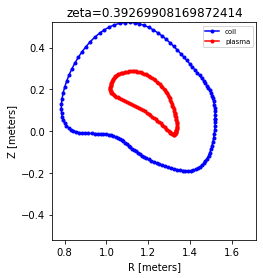

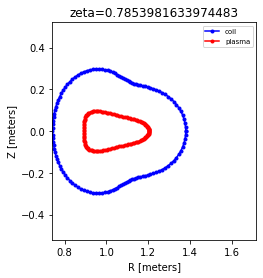

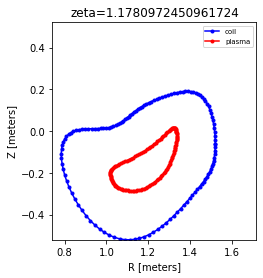

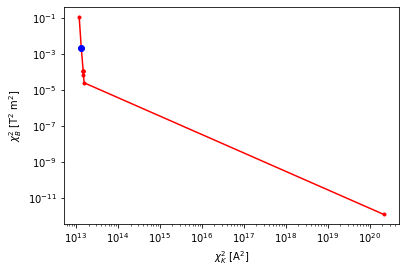

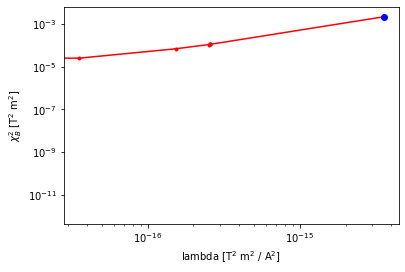

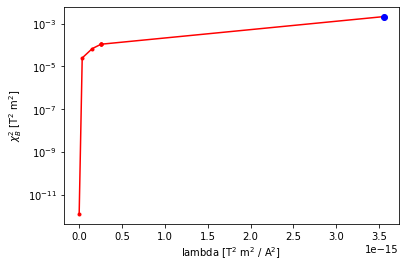

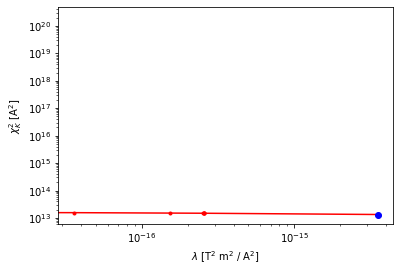

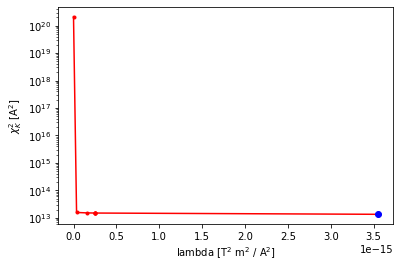

<Figure size 432x288 with 0 Axes>

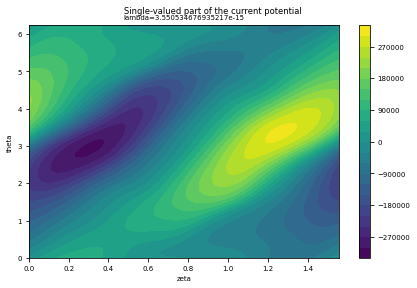

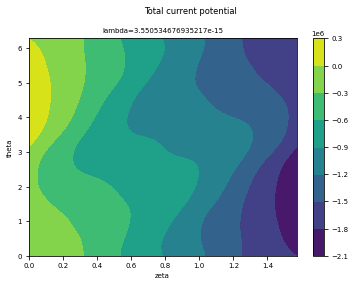

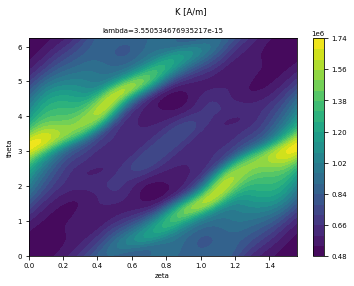

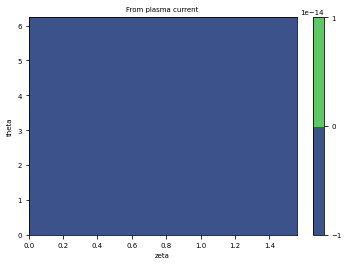

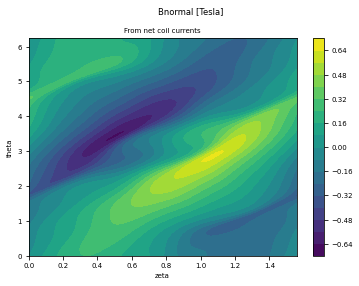

In [1]:
from regcoilPlot import *
regcoilPlot('regcoil_hsx/regcoil_out.hsx.nc')

The script cutCoilsFromRegcoil.py displays the contours for the coil shapes. In the example below, we are asking for 6 coils per half period to match the number of coils in the HSX experiment. This script will produce a file named coils.\*, where the extentension matches that of the regcoil_out.\*.nc provided.

In [28]:
from cutCoilsFromRegcoil import *
filename = 'regcoil_hsx/regcoil_out.hsx.nc'
nescinFilename = 'regcoil_hsx/nescin.hsx'
coilsPerHalfPeriod = 6
thetaShift = 0 # Only change this parameter if the script has difficulty finding the contours
ilambda = -1 # Changes which regularization parameter to use for comparison
cutCoilsFromRegcoil(filename,nescinFilename,coilsPerHalfPeriod,thetaShift,ilambda)

coilsFilename: coils.hsx
coilsPerHalfPeriod: 6
thetaShift: 0
ilambda: -1
Number of Fourier modes in coil surface from nescin file:  50

Minimum coil separation: 0.08198313062546637


We will now compare the coils obtained from REGCOIL and FOCUS. We will also plot the actual filamentary HSX coils.

In [36]:
%matplotlib qt
from coilpy.coils import Coil
import matplotlib.pyplot as plt

coilObject_regcoil = Coil.read_makegrid('coils.hsx') # This should point to coils.* file produced from the cutCoilsFromRegcoil script
coilObject_focus = Coil.read_makegrid('focus_hsx/hsx.coils') # This should point to the *.coils file produced from FOCUS
coilObject_hsx = Coil.read_makegrid('coils.hsx_actual') # This file is provided in this directory (actual coil set)
nfp = 4
ncoils = coilObject_hsx.num
i = 0 
for this_focus in coilObject_focus:
    if i in range(0,int(ncoils),int(2*nfp)):
        if i == 0:
            this_focus.plot(engine='pyplot',color='blue',label='FOCUS')
        else:
            this_focus.plot(engine='pyplot',color='blue')
    i += 1
i = 0 
for this_hsx in coilObject_hsx:
    if i in range(0,6):
        if i == 0:
            this_hsx.plot(engine='pyplot',color='green',label='Actual')
        else:
            this_hsx.plot(engine='pyplot',color='green')
    i += 1
i = 0 
for this_regcoil in coilObject_regcoil:
    if i in range(0,int(ncoils/2),int(nfp)):
        if i == 0:
            this_regcoil.plot(engine='pyplot',color='red',label='REGCOIL')
        else:
            this_regcoil.plot(engine='pyplot',color='red')
    i += 1
plt.legend()

As REGCOIL computes the normal field on the target plasma boundary from a continuos current sheet, we will now compute the corresponding normal field from the filamentary coils cut from the current potential. We will compare this with the normal field obtained from the actual coil set and the coils obtained from FOCUS.

We first read in the desired boundary on which we compute the normal field error

In [37]:
from coilpy.surface import FourSurf
regcoilSurf = FourSurf.read_vmec_output('regcoil_hsx/wout_hsx.nc')

We now compute the normal vector on a uniform grid on this surface

In [38]:
import numpy as np
ntheta = 50 # number of poloidal grid points 
nzeta = 50 # number of toroidal grid points

thetas = np.linspace(0,2*np.pi,ntheta)
zetas = np.linspace(0,2*np.pi,nzeta)
[thetas_2d,zetas_2d] = np.meshgrid(thetas,zetas)

# Compute normal vector
[x,y,z,n] = regcoilSurf.xyz(theta=thetas_2d,zeta=zetas_2d,normal=True)
x = np.reshape(x,np.shape(thetas_2d))
y = np.reshape(y,np.shape(thetas_2d))
z = np.reshape(z,np.shape(thetas_2d))

norm_n = np.sqrt(n[:,0]**2 + n[:,1]**2 + n[:,2]**2)
nx = np.reshape(n[:,0]/norm_n,np.shape(thetas_2d))
ny = np.reshape(n[:,1]/norm_n,np.shape(thetas_2d))
nz = np.reshape(n[:,2]/norm_n,np.shape(thetas_2d))

Now we compute the magnetic field from the 3 coil sets on this grid. This might take some time. 

In [39]:
# Compute magnetic field
B_regcoil = np.zeros((3,nzeta,ntheta))
B_focus = np.zeros((3,nzeta,ntheta))
B_hsx = np.zeros((3,nzeta,ntheta))
for itheta in range(ntheta):
    for izeta in range(nzeta):
        pos = [x[izeta,itheta],y[izeta,itheta],z[izeta,itheta]]
        for this_coil in coilObject_regcoil:
            this_coil.fourier_tangent()
            B_regcoil[:,izeta,itheta] += this_coil.bfield(pos)
        for this_coil in coilObject_focus:
            this_coil.fourier_tangent()
            B_focus[:,izeta,itheta] += this_coil.bfield(pos)
        for this_coil in coilObject_hsx:
            this_coil.fourier_tangent()
            B_hsx[:,izeta,itheta] += this_coil.bfield(pos)
            
Bn_regcoil = nx*B_regcoil[0,:,:] + ny*B_regcoil[1,:,:] + nz*B_regcoil[2,:,:]
Bn_focus = nx*B_focus[0,:,:] + ny*B_focus[1,:,:] + nz*B_focus[2,:,:]
Bn_hsx = nx*B_hsx[0,:,:] + ny*B_hsx[1,:,:] + nz*B_hsx[2,:,:]

We now plot the results

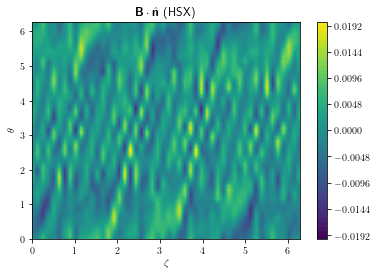

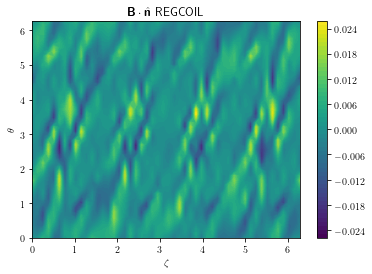

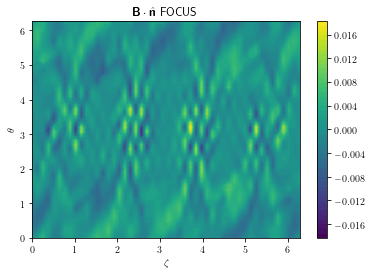

In [40]:
%matplotlib inline

plt.rc('text', usetex=True)
plt.title(r'$\textbf{B} \cdot \hat{\textbf{n}}$ (HSX)')
plt.contourf(zetas,thetas,Bn_hsx.T,50)
plt.xlabel(r'$\zeta$')
plt.ylabel(r'$\theta$')
plt.colorbar()

plt.figure()
plt.title(r'$\textbf{B} \cdot \hat{\textbf{n}}$ REGCOIL')
plt.contourf(zetas,thetas,Bn_regcoil.T,50)
plt.xlabel(r'$\zeta$')
plt.ylabel(r'$\theta$')
plt.colorbar()

plt.figure()
plt.title(r'$\textbf{B} \cdot \hat{\textbf{n}}$ FOCUS')
plt.contourf(zetas,thetas,Bn_focus.T,50)
plt.xlabel(r'$\zeta$')
plt.ylabel(r'$\theta$')
plt.colorbar()

We will now call free-boundary VMEC to assess the performance of these coil sets in more detail. Before we call VMEC, we must call the MAKEGRID code, which evaluates the vacuum field from the coils on a cylindrical grid. 

In order to call the MAKEGRID code, we need to compute the range of the cylindrical grid required.

We will demonstrate this for the coils obtained from REGCOIL

In [41]:
i = 0
for this_coil in coilObject_regcoil:
    this_R = np.sqrt(this_coil.x**2 + this_coil.y**2)
    this_Z = this_coil.z
    this_R_min = np.min(this_R)
    this_R_max = np.max(this_R)
    this_Z_min = np.min(this_Z)
    this_Z_max = np.max(this_Z)
    if (i == 0):
        R_min = this_R_min
        R_max = this_R_max
        Z_min = this_Z_min
        Z_max = this_Z_max
    else:
        R_min = min(this_R_min,R_min)
        R_max = max(this_R_max,R_max)
        Z_min = min(this_Z_min,Z_min)
        Z_max = max(this_Z_max,Z_max)
    i += 1

print('Rmin = '+str(R_min))
print('Rmax = '+str(R_max))
print('Zmin = '+str(Z_min))
print('Zmax = '+str(Z_max))

Rmin = 0.7433998346717483
Rmax = 1.7062751683432953
Zmin = -0.5659312716702913
Zmax = 0.5659312716702914


Once you have the range of the cylindrical grid, MAKEGRID can be called with the following steps.

1. Make a directory from which you will call MAKEGRID.
2. Copy sample files from mgrid_regcoil (input_xgrid.dat and script) as well as the coils.* file produced from REGCOIL.
3. Edit input_xgrid.dat with the correct range of your cylindrical grid and the name of the coils.* file.
4. Execute MAKEGRID using the script file.

This will produce an output netcdf file called mgrid_\*.nc as well as a file with the magnitudes of the currents in your coils, called extcur.\*.

Once you have called MAKEGRID, we will use the mgrid_\*.nc file to call free-boundary VMEC with the following steps.

1. Make a directory from which you will call VMEC.
2. Copy sample files from vmec_regcoil (input.hsx and script) as well as the mgrid_\*.nc file produced from MAKEGRID.
3. Edit the input file with the name of your mgrid_\*.nc file. Copy the values of the external currents from extcur.* into your input file.
4. Execute VMEC using the script.

The above procedure can be repeated using the coils file produced from FOCUS

We can evaluate the VMEC solution using the vmecPlot script provided in this directory.

mpol:  7
ntor:  4
Aminor_p:  0.12143363530274645
Rmajor_p:  1.2117201259128156
aspect:             9.978455498691723
Rmajor_p/Aminor_p:  9.978455498691723
betatotal:  0.0
betapol:    0.0
betator:    0.0
betaxis:    0.0
ctor:    -1.9549520422629252e-10


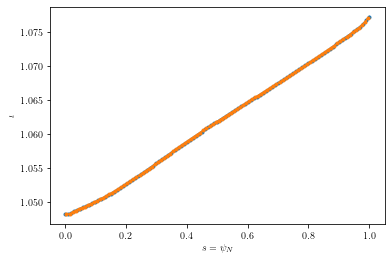

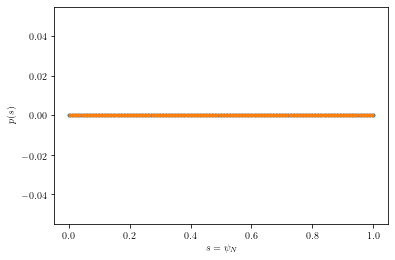

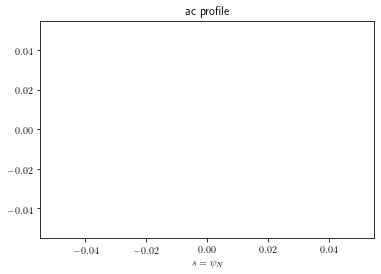

TimeoutError: Lock error: Matplotlib failed to acquire the following lock file:
    /Users/elizabeth/.matplotlib/tex.cache/739add4f87c1d1fc58b1bb4c9aee1c49.tex.matplotlib-lock
This maybe due to another process holding this lock file.  If you are sure no
other Matplotlib process is running, remove this file and try again.

<Figure size 432x288 with 2 Axes>

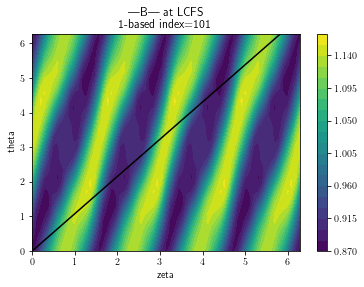

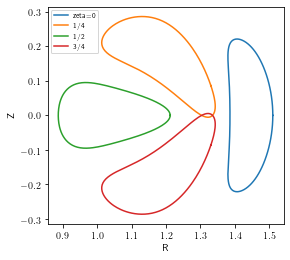

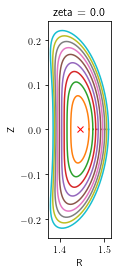

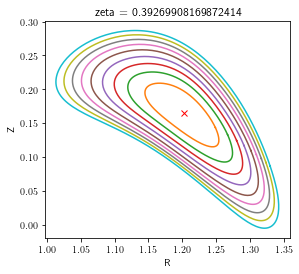

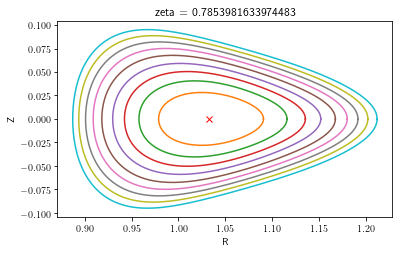

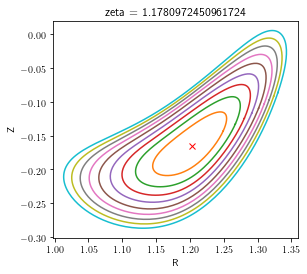

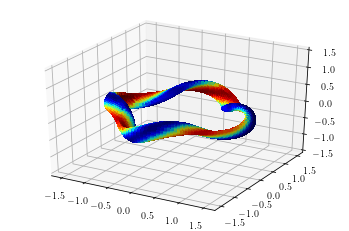

In [43]:
from vmecPlot import *
%matplotlib inline
vmecPlot('vmec_regcoil/wout_hsx.nc')

From the free-boundary equilibria, we compare with the desired fixed-boundary equilibrium. 

In [44]:
from simsopt.modules.vmec.output import VmecOutput
vmec_regcoil = VmecOutput('vmec_regcoil/wout_hsx.nc')
vmec_target = VmecOutput('regcoil_hsx/wout_hsx.nc')
vmec_focus = VmecOutput('vmec_focus/wout_hsx.nc')

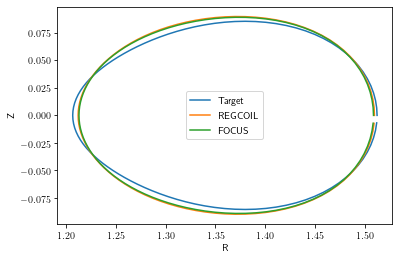

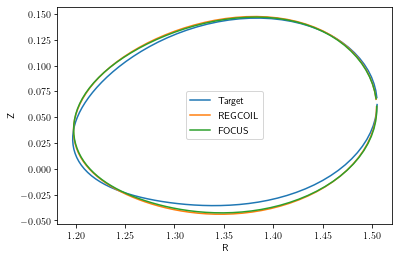

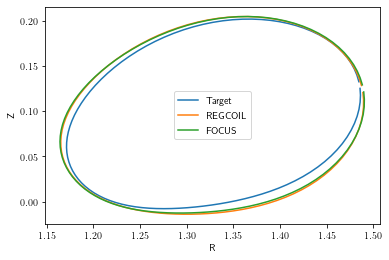

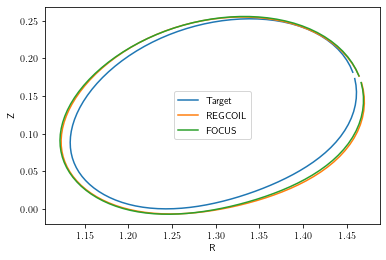

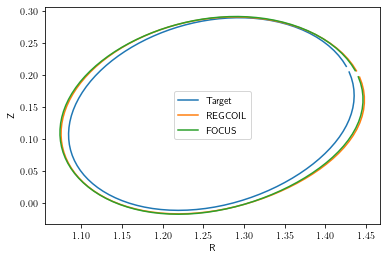

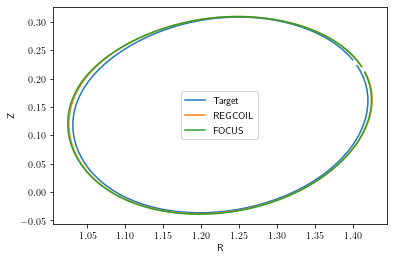

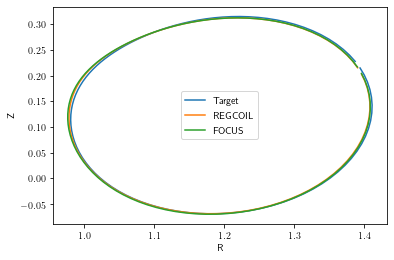

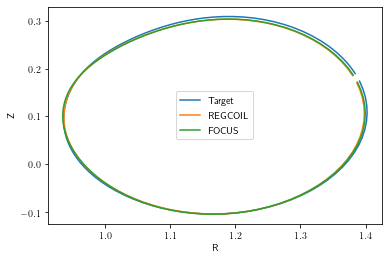

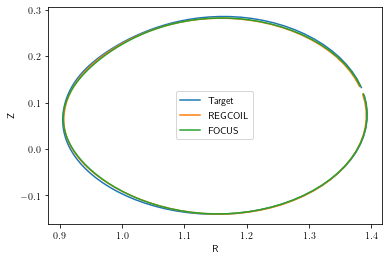

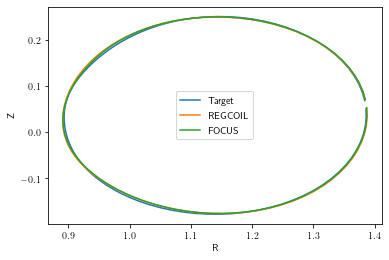

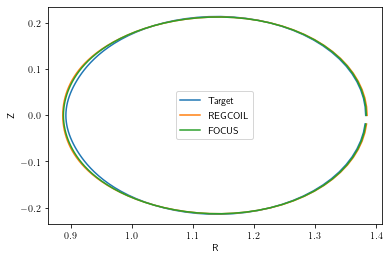

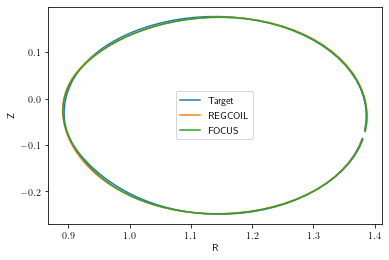

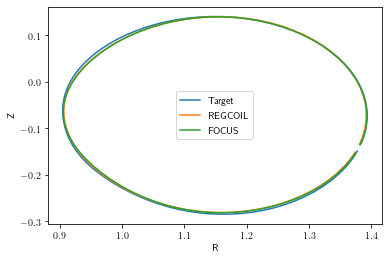

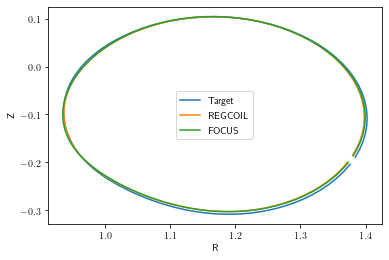

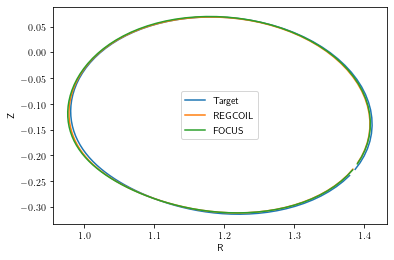

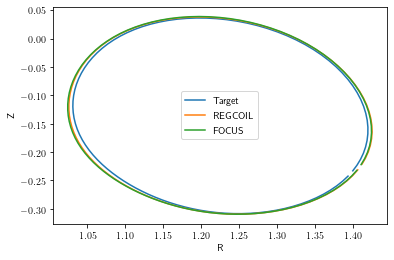

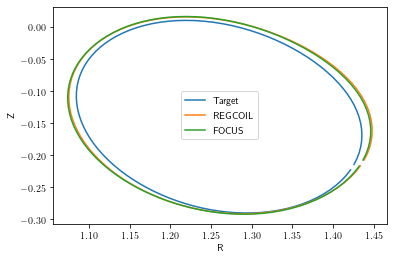

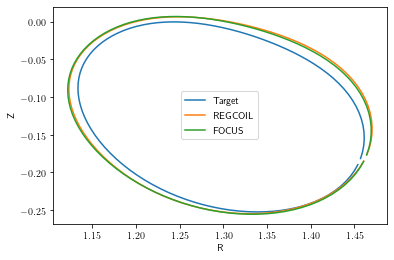

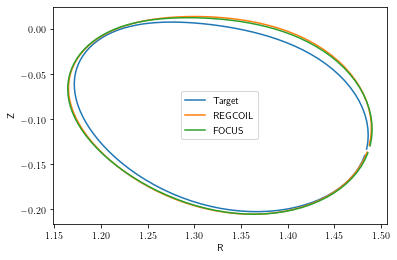

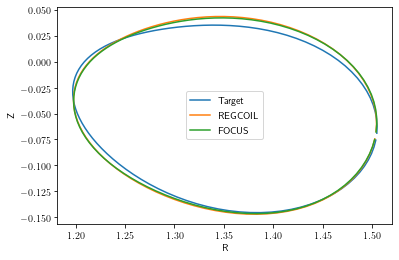

In [45]:
[X_target,Y_target,Z_target,R_target] = vmec_target.compute_position()
[X_regcoil,Y_regcoil,Z_regcoil,R_regcoil] = vmec_regcoil.compute_position()
[X_focus,Y_focus,Z_focus,R_focus] = vmec_focus.compute_position()

for iphi in range(0,vmec_target.nzeta,5):
    plt.figure()
    plt.plot(R_target[:,iphi],Z_target[:,iphi])
    plt.plot(R_regcoil[:,iphi],Z_regcoil[:,iphi])
    plt.plot(R_focus[:,iphi],Z_focus[:,iphi])
    plt.xlabel('R')
    plt.ylabel('Z')
    plt.legend(['Target','REGCOIL','FOCUS'])

We can also compute the quasi-symmetry properties of the coil sets using the BOOZXFORM code, which performs the Boozer coordinate transformation. This will provide the Fourier harmonics of the magnetic field strength on a surface in Boozer coordinates,

$B = \sum_{m,n} B_{m,n} \cos(m \vartheta_B - n \zeta_B)$,

where $\vartheta_B$ and $\zeta_B$ are the Boozer poloidal and toroidal angles, respectively.

To call the BOOZXFORM code, we will perform the following steps

1. Create a directory from which you would like to call BOOZXFORM.
2. Copy the sample files from boozxform_regcoil (in_booz.hsx and script). 
3. Copy the VMEC output file (wout_\*.nc) into this directory. Edit the input file to reflect the file extension of your output file.
4. Execute the code using the provided script.

The output of the BOOZXFORM code can be analyzed with the following code. 

The following set of code plots the field strength in Boozer coordinates. The black line shows a curve along which $\zeta_B = N_P \vartheta_B$, where $N_P$ is the number of field periods. You should see that the field strength is approximately constant along lines with this slope due to the helical quasisymmetry of HSX.

Text(0.5, 1.0, 'B')

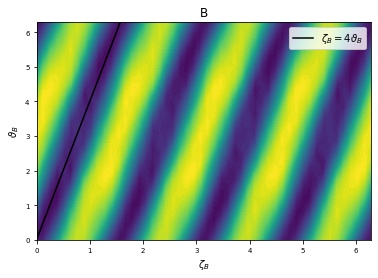

In [24]:
max_m = 10 # maximum poloidal mode number to plot
max_n = 10 # maximum toroidal mode number to plot
filename = 'boozxform_regcoil/boozmn_hsx.nc' # boozxform output file 

from scipy.io import netcdf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

f = netcdf.netcdf_file(filename,mode='r',mmap=False)

phi_b = f.variables['phi_b'][()]
ns_b = f.variables['ns_b'][()]
nfp_b = f.variables['nfp_b'][()]
ixn_b = f.variables['ixn_b'][()]
ixm_b = f.variables['ixm_b'][()]
bmnc_b = f.variables['bmnc_b'][()]
jlist = f.variables['jlist'][()]
f.close()
nmodes = len(ixn_b)

ntheta = 50 # number of poloidal grid points 
nzeta = 50 # number of toroidal grid points

thetas = np.linspace(0,2*np.pi,ntheta)
zetas = np.linspace(0,2*np.pi,nzeta)
[thetas_2d,zetas_2d] = np.meshgrid(thetas,zetas)

B_booz = np.zeros(np.shape(thetas_2d))
for im in range(len(ixn_b)):
    angle = ixm_b[im]*thetas_2d - ixn_b[im]*zetas_2d
    B_booz += bmnc_b[-1,im]*np.cos(angle)
    
plt.contourf(zetas,thetas,B_booz.T,50)
plt.plot(zetas/4,thetas,color='black')
plt.xlabel(r'$\zeta_B$')
plt.ylabel(r'$\vartheta_B$')
plt.legend([r'$\zeta_B = 4\vartheta_B$'])
plt.title(r'B')

We now plot the Fourier harmonics ($B_{m,n}$) as a function of the toroidal flux label. We sort the modes between the constant background, quasiaxisymmetric, mirror, and helical modes. You should find that the helical and background modes have the largest magnitude.

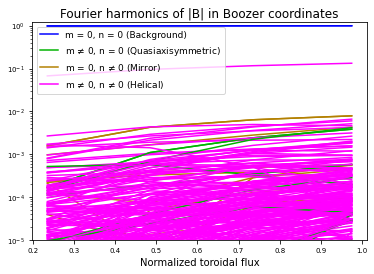

In [29]:
fig = plt.figure()

s = (jlist-1.5)/(ns_b-1.0)

backgroundColor='b'
QAColor=[0,0.7,0]
mirrorColor=[0.7,0.5,0]
helicalColor=[1,0,1]

scale_factor = np.max(np.abs(bmnc_b))

# First, plot just the 1st mode of each type, so the legend looks nice.

for imode in range(nmodes):
    if ixn_b[imode]==0 and ixm_b[imode]==0:
        plt.semilogy(s,abs(bmnc_b[:,imode])/scale_factor, color=backgroundColor,label='m = 0, n = 0 (Background)')
        break
for imode in range(nmodes):
    if ixn_b[imode]==0 and ixm_b[imode]!=0:
        plt.semilogy(s,abs(bmnc_b[:,imode])/scale_factor, color=QAColor,label=r'm $\ne$ 0, n = 0 (Quasiaxisymmetric)')
        break
for imode in range(nmodes):
    if ixn_b[imode]!=0 and ixm_b[imode]==0:
        plt.semilogy(s,abs(bmnc_b[:,imode])/scale_factor, color=mirrorColor,label=r'm = 0, n $\ne$ 0 (Mirror)')
        break
for imode in range(nmodes):
    if ixn_b[imode]!=0 and ixm_b[imode]!=0:
        plt.semilogy(s,abs(bmnc_b[:,imode])/scale_factor, color=helicalColor,label=r'm $\ne$ 0, n $\ne$ 0 (Helical)')
        break
plt.legend(fontsize=9,loc=2)
for imode in range(nmodes):
    if np.abs(ixm_b[imode]) > max_m:
        continue
    if np.abs(ixn_b[imode]) > max_n * nfp_b:
        continue
    if ixn_b[imode]==0:
        if ixm_b[imode]==0:
            mycolor = backgroundColor
        else:
            mycolor = QAColor
    else:
        if ixm_b[imode]==0:
            mycolor = mirrorColor
        else:
            mycolor = helicalColor
    plt.semilogy(s,abs(bmnc_b[:,imode])/scale_factor, color=mycolor)

plt.xlabel('Normalized toroidal flux')
plt.title('Fourier harmonics of |B| in Boozer coordinates')
plt.ylim([1e-5,1.2])
# plt.xlim([0,1])

plt.show()

To quantify the degree of quasihelical symmetry, we sum over the modes that break the helical symmetry ($m \ne n/N_P$), dividing by the total magnitude of the mdoes

Text(0, 0.5, 'QA metric')

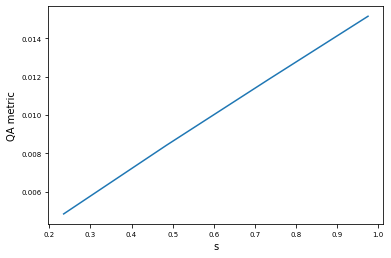

In [30]:
QA_metric = np.zeros(len(jlist))
for index in range(len(jlist)):
    summed_total = 0
    summed_nonQA = 0
    for imode in range(nmodes):
        if ((ixm_b[imode]==ixn_b[imode]/4)==False):
            summed_nonQA += bmnc_b[index,imode]**2
        summed_total += bmnc_b[index,imode]**2
    # Normalize by total
    QA_metric[index] = np.sqrt(summed_nonQA/summed_total)
    
plt.plot(s,QA_metric)
plt.xlabel('s')
plt.ylabel('QA metric')

Perform the same analysis with the equilibrium generated by the FOCUS coils. How does the degree of quasisymmetry compare?

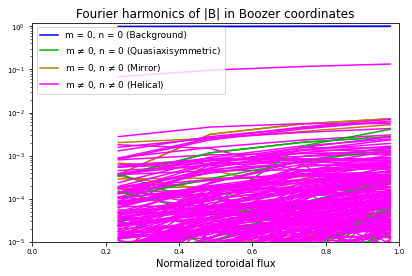

Text(0, 0.5, 'QA metric')

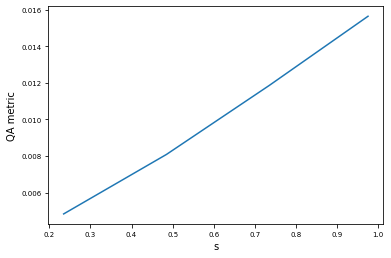

In [31]:
max_m = 10 # maximum poloidal mode number to plot
max_n = 10 # maximum toroidal mode number to plot
filename = 'boozxform_focus/boozmn_hsx.nc'

from scipy.io import netcdf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

f = netcdf.netcdf_file(filename,mode='r',mmap=False)

phi_b = f.variables['phi_b'][()]
ns_b = f.variables['ns_b'][()]
nfp_b = f.variables['nfp_b'][()]
ixn_b = f.variables['ixn_b'][()]
ixm_b = f.variables['ixm_b'][()]
bmnc_b = f.variables['bmnc_b'][()]
jlist = f.variables['jlist'][()]
f.close()
nmodes = len(ixn_b)

fig = plt.figure()

s = (jlist-1.5)/(ns_b-1.0)

backgroundColor='b'
QAColor=[0,0.7,0]
mirrorColor=[0.7,0.5,0]
helicalColor=[1,0,1]

scale_factor = np.max(np.abs(bmnc_b))

# First, plot just the 1st mode of each type, so the legend looks nice.

for imode in range(nmodes):
    if ixn_b[imode]==0 and ixm_b[imode]==0:
        plt.semilogy(s,abs(bmnc_b[:,imode])/scale_factor, color=backgroundColor,label='m = 0, n = 0 (Background)')
        break
for imode in range(nmodes):
    if ixn_b[imode]==0 and ixm_b[imode]!=0:
        plt.semilogy(s,abs(bmnc_b[:,imode])/scale_factor, color=QAColor,label=r'm $\ne$ 0, n = 0 (Quasiaxisymmetric)')
        break
for imode in range(nmodes):
    if ixn_b[imode]!=0 and ixm_b[imode]==0:
        plt.semilogy(s,abs(bmnc_b[:,imode])/scale_factor, color=mirrorColor,label=r'm = 0, n $\ne$ 0 (Mirror)')
        break
for imode in range(nmodes):
    if ixn_b[imode]!=0 and ixm_b[imode]!=0:
        plt.semilogy(s,abs(bmnc_b[:,imode])/scale_factor, color=helicalColor,label=r'm $\ne$ 0, n $\ne$ 0 (Helical)')
        break
plt.legend(fontsize=9,loc=2)
for imode in range(nmodes):
    if np.abs(ixm_b[imode]) > max_m:
        continue
    if np.abs(ixn_b[imode]) > max_n * nfp_b:
        continue
    if ixn_b[imode]==0:
        if ixm_b[imode]==0:
            mycolor = backgroundColor
        else:
            mycolor = QAColor
    else:
        if ixm_b[imode]==0:
            mycolor = mirrorColor
        else:
            mycolor = helicalColor
    plt.semilogy(s,abs(bmnc_b[:,imode])/scale_factor, color=mycolor)

plt.xlabel('Normalized toroidal flux')
plt.title('Fourier harmonics of |B| in Boozer coordinates')
plt.ylim([1e-5,1.2])
plt.xlim([0,1])

plt.subplots_adjust(top=0.9,bottom=0.14,left=0.09,right=0.94)

plt.show()

QA_metric = np.zeros(len(jlist))
for index in range(len(jlist)):
    summed_total = 0
    summed_nonQA = 0
    for imode in range(nmodes):
        if ((ixm_b[imode]==ixn_b[imode]/4)==False):
            summed_nonQA += bmnc_b[index,imode]**2
        summed_total += bmnc_b[index,imode]**2
    # Normalize by to
    QA_metric[index] = np.sqrt(summed_nonQA/summed_total)
    
plt.plot(s,QA_metric)
plt.xlabel('s')
plt.ylabel('QA metric')